In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Purpose: first iteration of training a faster rcnn network on the
foot dataset from hike

Pseudocode:
1) Import dataset and apply normalizations
a. convert to a dataset class
    i. Define augmentations
    2. normalize the data
    3. one-hot encode data
b. create a dataloader

2) Create the model
a. use the faster_rcnn model from torchvision
b. replace the last layer because have very few datapoints

3) Create the optimization and hyperparameters

4) Train model
a. check validation and other metrics throughout

5) Validate:
a. Run forward inference to visualize example (use nms)

5) Run on Test set
a. visualize results
"""

'\nPurpose: first iteration of training a faster rcnn network on the\nfoot dataset from hike\n\nPseudocode:\n1) Import dataset and apply normalizations\na. convert to a dataset class\n    i. Define augmentations\n    2. normalize the data\n    3. one-hot encode data\nb. create a dataloader\n\n2) Create the model\na. use the faster_rcnn model from torchvision\nb. replace the last layer because have very few datapoints\n\n3) Create the optimization and hyperparameters\n\n4) Train model\na. check validation and other metrics throughout\n\n5) Validate:\na. Run forward inference to visualize example (use nms)\n\n5) Run on Test set\na. visualize results\n'

In [3]:
# %%shell

# pip3 install pytorch-lightning
# pip3 install importlib-metadata

In [4]:
%%shell

#cd /content
# git clone https://github.com/bacelii/python_tools.git
# pip3 install -e python_tools
#pip3 install -e /content/drive/MyDrive/Grad_Classes/Hike/object_detection_utils/

# Importing the dataset

In [5]:
import logging
import pathlib
import sys
from dataclasses import asdict, dataclass, field
from typing import Dict, List, Optional, Tuple

import albumentations
import numpy as np
from pydantic import BaseSettings, Field
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.loggers.neptune import NeptuneLogger
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FasterRCNN

from object_detection_utils.backbone_resnet import ResNetBackbones
from object_detection_utils.datasets import ObjectDetectionDataSet
from object_detection_utils.faster_RCNN import (
    FasterRCNNLightning,
    get_faster_rcnn_resnet,
)
from object_detection_utils.transformations import (
    AlbumentationWrapper,
    Clip,
    ComposeDouble,
    FunctionWrapperDouble,
    normalize_01,
)
from object_detection_utils.utils import (
    collate_double,
    get_filenames_of_path,
    log_model_neptune,
)

/usr/local/lib/python3.10/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/neptune.py:40: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune


In [6]:
from pathlib import Path
ROOT_PATH = "/content/drive/MyDrive/Grad_Classes/Hike/object_detection_utils/Applications/foot_faster_rcnn"

data_path: Path = (
        ROOT_PATH  / Path("data/train")
)

data_path.exists()

True

In [14]:
@dataclass
class Parameters:
    """
    Dataclass for the parameters.
    """

    BATCH_SIZE: int = 2
    CACHE: bool = True
    SAVE_DIR: Optional[
        str
    ] = None  # checkpoints will be saved to cwd (current working directory) if None
    LOG_MODEL: bool = False  # whether to log the model to neptune after training
    ACCELERATOR: Optional[str] = "auto"  # set to "gpu" if you want to use GPU
    LR: float = 0.001
    PRECISION: int = 32
    CLASSES: int = 2
    SEED: int = 42
    MAXEPOCHS: int = 200
    PATIENCE: int = 50
    BACKBONE: ResNetBackbones = ResNetBackbones.RESNET34
    FPN: bool = False
    ANCHOR_SIZE: Tuple[Tuple[int, ...], ...] = ((32, 64, 128, 256, 512),)
    ASPECT_RATIOS: Tuple[Tuple[float, ...]] = ((0.5, 1.0, 2.0),)
    MIN_SIZE: int = 1024
    MAX_SIZE: int = 1025
    IMG_MEAN: List = field(default_factory=lambda: [0.485, 0.456, 0.406])
    IMG_STD: List = field(default_factory=lambda: [0.229, 0.224, 0.225])
    IOU_THRESHOLD: float = 0.5
    FAST_DEV_RUN: bool = False

    def __post_init__(self):
        if self.SAVE_DIR is None:
            self.SAVE_DIR: str = str(pathlib.Path.cwd())

parameters = Parameters()

# Testing Neptune logger

In [11]:
#!pip3 install pydantic[dotenv]
#!pip3 install -U 'neptune-client'

In [12]:
class NeptuneSettings(BaseSettings):
    """
    Reads the variables from the environment.
    Errors will be raised if the required variables are not set.
    """
    api_key: str = Field(env="NEPTUNE")
    OWNER: str = "brendanacelii"  # set your name here, e.g. johndoe22
    PROJECT: str = "Object-Detection-FasterRCNN"  # set your project name here, e.g. Heads
    EXPERIMENT: str = "complete-retrain"  # set your experiment name here, e.g. heads

    class Config:
        # this tells pydantic to read the variables from the .env file
        env_file = str((ROOT_PATH / Path(".env")).absolute())

neptune_settings: NeptuneSettings = NeptuneSettings()

In [15]:
neptune_logger: NeptuneLogger = NeptuneLogger(
        api_key=neptune_settings.api_key,
        project=f"{neptune_settings.OWNER}/{neptune_settings.PROJECT}",  # use your neptune name here
        name=neptune_settings.EXPERIMENT,
        log_model_checkpoints=False,
)

"""
Purpose: Will save thehyperparameters in Run metadata > [run name] > training > hyperparameters
"""
neptune_logger.log_hyperparams(asdict(parameters))

neptune_logger.experiment.stop()

https://app.neptune.ai/brendanacelii/Object-Detection-FasterRCNN/e/OB-2
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.
All 17 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/brendanacelii/Object-Detection-FasterRCNN/e/OB-2/metadata


# Running the dataset

In [10]:
inputs_train: List[pathlib.Path] = get_filenames_of_path(data_path / "images")
targets_train: List[pathlib.Path] = get_filenames_of_path(data_path / "labels")

inputs_train.sort()
targets_train.sort()

mapping: Dict[str, int] = {
    "T1": 1,
    "T2": 2,
    "T3":3,
    "T4": 4,
    "T5": 5,
    "MT1":6,
    "MT5":7,
    "CBL":8,
    "CBR":9,
    "CTL":10,
    "CTR":11
}

# training transformations and augmentations
transforms_training: ComposeDouble = ComposeDouble(
    [
        Clip(),
        AlbumentationWrapper(albumentation=albumentations.HorizontalFlip(p=0.5)),
        AlbumentationWrapper(
            albumentation=albumentations.RandomScale(p=0.5, scale_limit=0.5)
        ),
        # AlbuWrapper(albu=A.VerticalFlip(p=0.5)),
        FunctionWrapperDouble(function=np.moveaxis, source=-1, destination=0),
        FunctionWrapperDouble(function=normalize_01),
    ]
)

# dataset training
# dataset_train: ObjectDetectionDataSet = ObjectDetectionDataSet(
#     inputs=inputs_train,
#     targets=targets_train,
#     transform=transforms_training,
#     use_cache=parameters.CACHE,
#     convert_to_format=None,
#     mapping=mapping,
# )

In [ ]:
"""
Purpose: To plot a picture with bounding boxes
"""

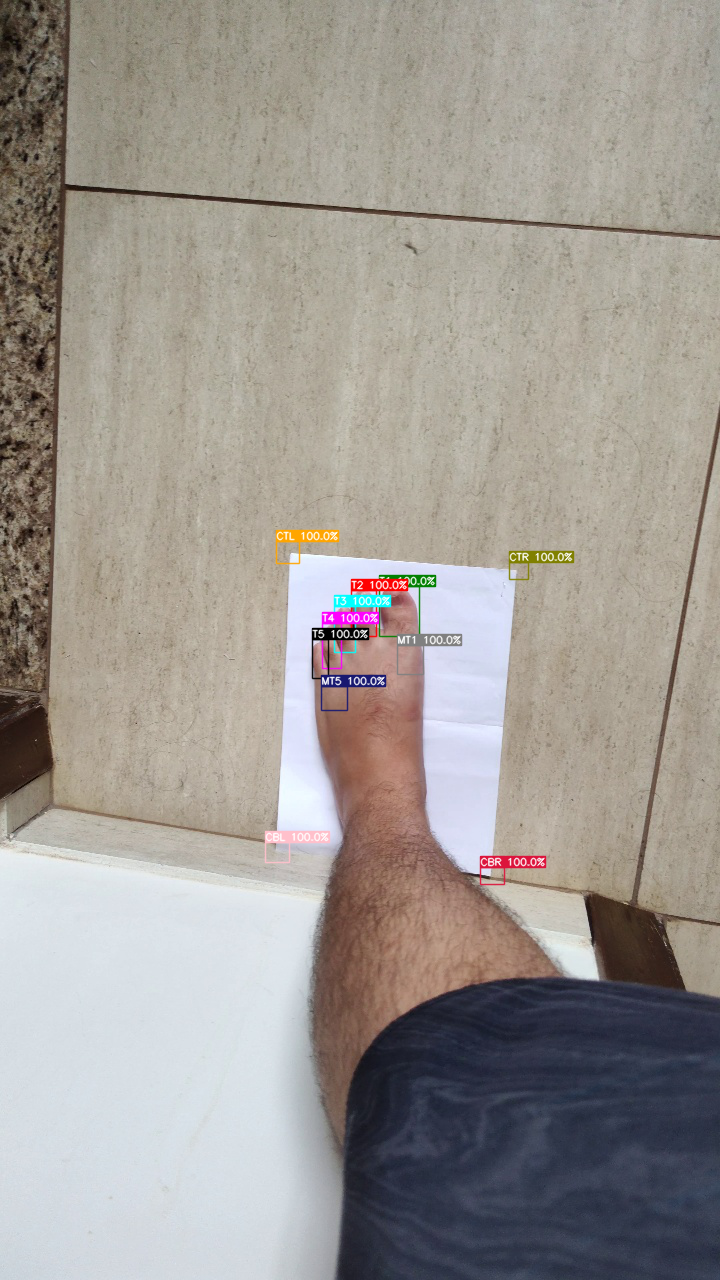

In [13]:
from object_detection_utils.visualizations import plot_bboxes_from_files

file_name = "004"
test_image = data_path / Path(f"images/{file_name}.jpg")
test_labels = data_path / Path(f"labels/{file_name}.json")
default_labels = list(mapping.keys())

plot_bboxes_from_files(
    test_image,
    test_labels,
    mapping=mapping,
    default_labels=default_labels
)

In [125]:
debug

> <ipython-input-124-6a298905fce8>(49)plot_bboxes()
     47     #add score in label if score=True
     48     if score :
---> 49       label = labels[int(box[-1])] + " " + str(round(100 * float(box[-2]),1)) + "%"
     50     else :
     51       label = labels[int(box[-1])]

ipdb> labels
['T1', 'T2', 'T3', 'T4', 'T5', 'MT1', 'MT5', 'CBL', 'CBR', 'CTL', 'CTR']
ipdb> c


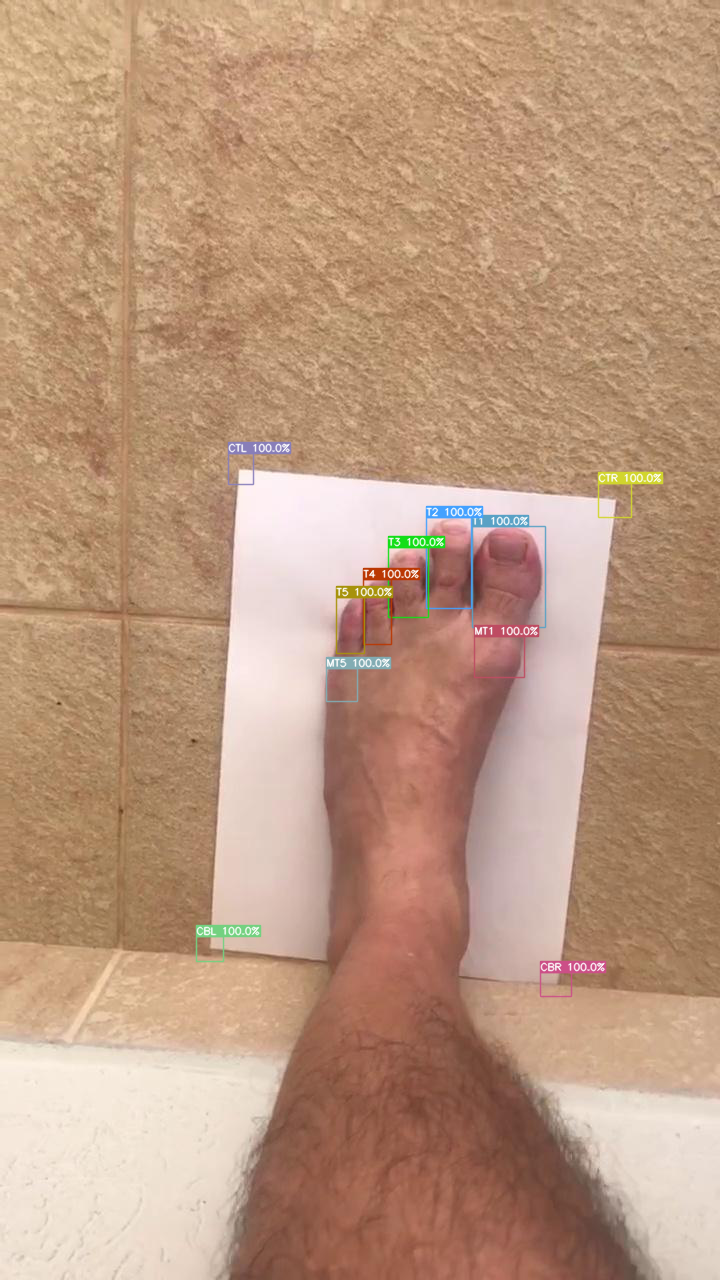

In [72]:
debug

> <ipython-input-69-fe34eb8c9d21>(35)plot_bboxes()
     33     #add score in label if score=True
     34     if score :
---> 35       label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
     36     else :
     37       label = labels[int(box[-1])+1]

ipdb> int(box[-1])+1
12
ipdb> c



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 347, in set_continue
    sys.settrace(None)



In [ ]:
class NeptuneSettings(BaseSettings)

run = neptune.init_run(
    project="brendanacelii/Object-Detection-FasterRCNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOWEyN2UxMS0wN2ViLTRlMTEtYWU4Yy0wMWZkN2UzOGJiYTYifQ==",
)

# Testing

In [ ]:
import object_detection_utils as odu
from object_detection_utils.metrics import bounding_box

In [ ]:
from python_tools import networkx_utils as xu

In [ ]:
# basic setup and monitoring modules

import logging
import pathlib
import sys
from dataclasses import asdict, dataclass, field
from typing import Dict, List, Optional, Tuple


import albumentations
import numpy as np
from pydantic import BaseSettings, Field
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.loggers.neptune import NeptuneLogger
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FasterRCNN

In [ ]:
from object_detection_utils.backbone_resnet import ResNetBackbones
from object_detection_utils.datasets import ObjectDetectionDataSet
from object_detection_utils.faster_RCNN import (
    FasterRCNNLightning,
    get_faster_rcnn_resnet,
)
from object_detection_utils.transformations import (
    AlbumentationWrapper,
    Clip,
    ComposeDouble,
    FunctionWrapperDouble,
    normalize_01,
)
from object_detection_utils.utils import (
    collate_double,
    get_filenames_of_path,
    log_model_neptune,
)

In [ ]:
import object_detection_utils.torch_model_utils as tmu

In [ ]:
from object_detection_utils.backbone_resnet import ResNetBackbones
ResNetBackbones.RESNET34

import object_detection_utils.torch_model_utils as tmu

model = tmu.get_resnet_model(ResNetBackbones.RESNET34)
tmu.freeze_all_layers_except(
    model,
    layers_to_train = ['layer4'],
    verbose = True,
)

from torchsummary import summary
summary(model,(3,288,288,))

layers_to_train = ['layer4', 'fc']
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 144, 144]           9,408
       BatchNorm2d-2         [-1, 64, 144, 144]             128
              ReLU-3         [-1, 64, 144, 144]               0
         MaxPool2d-4           [-1, 64, 72, 72]               0
            Conv2d-5           [-1, 64, 72, 72]           4,096
       BatchNorm2d-6           [-1, 64, 72, 72]             128
              ReLU-7           [-1, 64, 72, 72]               0
            Conv2d-8           [-1, 64, 72, 72]          36,864
       BatchNorm2d-9           [-1, 64, 72, 72]             128
             ReLU-10           [-1, 64, 72, 72]               0
           Conv2d-11          [-1, 256, 72, 72]          16,384
      BatchNorm2d-12          [-1, 256, 72, 72]             512
           Conv2d-13          [-1, 256, 72, 72]          16,384
    

In [ ]:
from torchvision.models import resnet
from torchsummary import summary

def enum_extract_value(name):
    if "enum" in str(type(name)):
        name = name.value
    return name

def get_resnet_model(name,pretrained = True):
    name = enum_extract_value(
        name = ResNetBackbones.RESNET101
    )

    if pretrained:
        weights_name = name.replace('r',"R").replace('n',"N")
        weights=f'{weights_name}_Weights.DEFAULT'
    else:
        weights = None

    model = resnet.__dict__[name](
        weights = weights
    )
    return model

def freeze_parameters(parameter):
    parameter.requires_grad_(False)

def freeze_all_layers_except(
    model,
    layers_to_train=None,
    unfreeze_fc = True,
    verbose = False,
    ):
    """
    Purpose: freeze the parameters of all layers
    except those in list

    """
    if layers_to_train is None:
        layers_to_train = []
    if 'fc' not in layers_to_train and unfreeze_fc:
        layers_to_train.append('fc')


    if verbose:
        print(f"layers_to_train = {layers_to_train}")
    for name,parameter in model.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)

def layer_names(model):
    return [k[0] for k in list(model.named_parameters())]

model = get_resnet_model(ResNetBackbones.RESNET34)
freeze_all_layers_except(
    model,
    layers_to_train = ['layer4'],
    verbose = True,
)

summary(model,(3,288,288))

layers_to_train = ['layer4', 'fc']
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 144, 144]           9,408
       BatchNorm2d-2         [-1, 64, 144, 144]             128
              ReLU-3         [-1, 64, 144, 144]               0
         MaxPool2d-4           [-1, 64, 72, 72]               0
            Conv2d-5           [-1, 64, 72, 72]           4,096
       BatchNorm2d-6           [-1, 64, 72, 72]             128
              ReLU-7           [-1, 64, 72, 72]               0
            Conv2d-8           [-1, 64, 72, 72]          36,864
       BatchNorm2d-9           [-1, 64, 72, 72]             128
             ReLU-10           [-1, 64, 72, 72]               0
           Conv2d-11          [-1, 256, 72, 72]          16,384
      BatchNorm2d-12          [-1, 256, 72, 72]             512
           Conv2d-13          [-1, 256, 72, 72]          16,384
    

In [ ]:
for i,k in enumerate(list(model.children())):
    print(f"--- child {i} ----\n\n")
    print(k)

--- child 0 ----


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
--- child 1 ----


BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
--- child 2 ----


ReLU(inplace=True)
--- child 3 ----


MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
--- child 4 ----


Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1),

In [ ]:
model.out_channels = 1000

In [ ]:
# logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(filename)s:%(lineno)d:%(funcName)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

# root directory (project directory)
ROOT_PATH: pathlib.Path = pathlib.Path(__file__).parent.absolute()

In [ ]:
class NeptuneSettings(BaseSettings)

run = neptune.init_run(
    project="brendanacelii/Object-Detection-FasterRCNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOWEyN2UxMS0wN2ViLTRlMTEtYWU4Yy0wMWZkN2UzOGJiYTYifQ==",
)